## Import modules

In [1]:
import os
import os.path as osp
import sys
from random import randrange
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import datetime
import pytz
import torch
import torch.nn as nn
# from fhirpy import SyncFHIRClient
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
# from keras.layers import Dense, Flatten, Embedding, Multiply, Concatenate, Input
# from keras.layers.advanced_activations import LeakyReLU
# from keras.models import Model, Sequential
# from keras.optimizers import adam_v2
import csv
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def fix_all_seeds(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
fix_all_seeds(2021)

## Data

In [2]:
df_data = pd.read_csv("./input/data.csv")
df_data = df_data.rename(columns={"concave points_mean":"concave.points_mean", "concave points_se": "concave.points_se", "concave points_worst":"concave.points_worst", "diagnosis":"label"})
df_data = df_data.drop(["Unnamed: 32"], axis=1)

station_list = ["uka", "ukg", "ukk", "ukl", "imise", "mittweida"]
station_dfs = [pd.read_csv("./input/{}.csv".format(station)).rename(columns={"patient_id":"id"}) for station in station_list]
final_test_df = pd.read_csv("./input/final_test.csv").rename(columns={"patient_id":"id"})
for idx in range(len(station_list)):
    station_dfs[idx]["id"] = station_dfs[idx]["id"].map(lambda x: int(x[6:]))
    station_dfs[idx] = pd.merge(df_data, station_dfs[idx], on='id', how='right')
final_test_df["id"] = final_test_df["id"].map(lambda x: int(x[6:]))
final_test_df = pd.merge(df_data, final_test_df, on='id', how='right')

In [3]:
print(len(final_test_df) + len(station_dfs[0]) + len(station_dfs[1]) + len(station_dfs[2]) + len(station_dfs[3]) + len(station_dfs[4]) + len(station_dfs[5]))
print(len(df_data))
print(len(final_test_df))
print([len(station_dfs[idx]) for idx in range(len(station_dfs))])

569
569
228
[56, 56, 56, 56, 61, 56]


## EDA

35 21
35 21
35 21
35 21
39 22
35 21


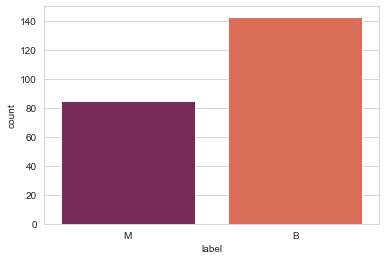

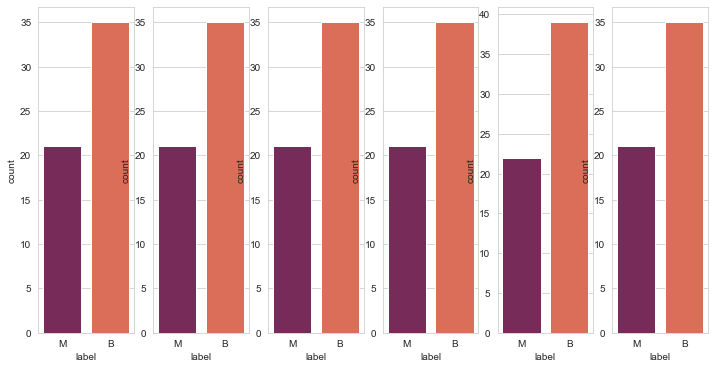

In [4]:
sns.set_style('whitegrid')
plt.figure()
sns.countplot(x="label", data=final_test_df, palette='rocket');

plt.figure(figsize=(12,6))
for idx in range(len(station_dfs)):
    plt.subplot(1,6,idx+1)
    B, M = station_dfs[idx]["label"].value_counts()
    print(B, M)
    sns.countplot(x="label", data=station_dfs[idx], palette='rocket');

In [5]:
X_FEATURES = ['radius_mean', 'texture_mean', 'perimeter_mean',
              'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
              'concave.points_mean', 'symmetry_mean', 'fractal_dimension_mean',
              'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
              'compactness_se', 'concavity_se', 'concave.points_se', 'symmetry_se',
              'fractal_dimension_se', 'radius_worst', 'texture_worst',
              'perimeter_worst', 'area_worst', 'smoothness_worst',
              'compactness_worst', 'concavity_worst', 'concave.points_worst',
              'symmetry_worst', 'fractal_dimension_worst']
Y_FEATURE = 'label'
df_mean_X = []
df_std_X = []

for idx in range(len(station_list)):
    df_mean_X.append(np.mean(station_dfs[idx][X_FEATURES], axis=0).to_numpy())
    df_std_X.append(np.std(station_dfs[idx][X_FEATURES], axis=0).to_numpy())

df_mean_X.append(np.mean(final_test_df[X_FEATURES], axis=0).to_numpy())
df_std_X.append(np.std(final_test_df[X_FEATURES], axis=0).to_numpy())
df_mean_X = pd.DataFrame(df_mean_X, columns=X_FEATURES)
df_std_X = pd.DataFrame(df_std_X, columns=X_FEATURES)
df_mean_X["station"] = pd.Series(station_list+["final test"])
df_std_X["station"] = pd.Series(station_list+["final test"])

In [6]:
df_mean_X.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave.points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave.points_worst,symmetry_worst,fractal_dimension_worst,station
0,13.731571,19.582857,89.354107,608.767857,0.094890,0.104666,0.082391,0.045645,0.177461,0.063306,...,26.149643,103.899643,812.069643,0.133315,0.269866,0.269384,0.113831,0.276321,0.086851,uka
1,14.397768,18.889821,93.583929,671.785714,0.096442,0.104018,0.088604,0.049828,0.180682,0.062323,...,25.928929,109.231786,907.616071,0.135511,0.269095,0.296277,0.122032,0.293105,0.085412,ukg
2,14.210804,19.831964,92.376071,662.580357,0.094050,0.098760,0.077473,0.045377,0.178232,0.062172,...,25.904821,108.191429,883.089286,0.125765,0.231277,0.229873,0.104961,0.277905,0.080141,ukk
3,14.041125,19.713036,91.210000,648.178571,0.094190,0.100675,0.080000,0.045794,0.179416,0.062446,...,26.035893,106.121786,877.585714,0.128090,0.237016,0.238041,0.108172,0.283812,0.081378,ukl
4,13.744197,18.907869,89.610820,617.924590,0.098141,0.106430,0.097691,0.052405,0.185074,0.064454,...,25.281967,104.514426,821.937705,0.136072,0.253771,0.284095,0.120542,0.306526,0.087015,imise


In [7]:
df_std_X.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave.points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave.points_worst,symmetry_worst,fractal_dimension_worst,station
0,2.926020,4.843530,20.201886,277.122168,0.014855,0.060492,0.070533,0.033302,0.026809,0.007918,...,7.397978,28.650615,450.418996,0.027678,0.192328,0.207938,0.066242,0.046357,0.019563,uka
1,3.228776,4.378659,21.740257,314.734701,0.013174,0.043006,0.066657,0.032307,0.020013,0.006693,...,6.753764,30.197674,522.003759,0.023050,0.159774,0.206911,0.059225,0.056542,0.021350,ukg
2,3.526905,4.576257,24.442783,329.270842,0.013011,0.052094,0.075330,0.039270,0.025404,0.005878,...,6.148746,34.081328,507.822445,0.018150,0.163689,0.198969,0.068884,0.052208,0.013139,ukk
3,3.583369,4.815006,24.590153,348.758869,0.012611,0.048429,0.067751,0.036131,0.027967,0.007328,...,6.378750,33.516174,587.667935,0.018573,0.132725,0.163827,0.059545,0.046832,0.015148,ukl
4,3.348225,4.023645,23.147326,319.766652,0.012573,0.047897,0.085303,0.038901,0.029158,0.007371,...,5.833279,31.048951,499.600696,0.021545,0.137068,0.192088,0.062331,0.075538,0.017028,imise


## Define model

In [8]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.hidden_layer = nn.Linear(input_dim, hidden_dim)
        self.sigmoid = nn.Sigmoid()
        self.output_layer = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        out = self.output_layer(self.sigmoid(self.hidden_layer(x)))
        return out

def train(X_train, y_train, model, criterion, optimizer):
    inputs = torch.from_numpy(X_train).float()
    targets = torch.from_numpy(y_train).long()
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    return loss.item()


def valid(X_test, y_test, model, criterion):
    inputs = torch.from_numpy(X_test).float()
    targets = torch.from_numpy(y_test).long()
    outputs = model(inputs)
    val_loss = criterion(outputs, targets)
    _, predicted = torch.max(outputs, 1)
    cm = confusion_matrix(targets.numpy(), predicted.numpy())
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    with np.errstate(divide='ignore', invalid='ignore'):
        val_acc = (tp + tn) / (tp + fp + fn + tn)
        val_precesion = tp / (tp + fp)
        val_recall = tp / (tp + fn)
        val_f1_score = 2 * tp / (2 * tp + fn + fp)
    return val_loss.item(), val_acc, val_precesion, val_recall, val_f1_score

## Prepare Final Test Dataset

In [9]:
test_scaler = StandardScaler()
X_test = final_test_df[X_FEATURES]
y_test = final_test_df[Y_FEATURE]
X_test = test_scaler.fit_transform(X_test)
y_test.replace(to_replace=dict(M=1, B=0), inplace=True)
y_test = y_test.to_numpy()

## Single Site Training

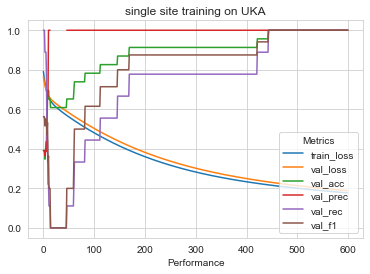

single site training on UKA
test loss 0.1923772096633911
test_acc 0.9649122807017544
test_prec 0.963855421686747
test_rec 0.9411764705882353
test_f1 0.9523809523809523




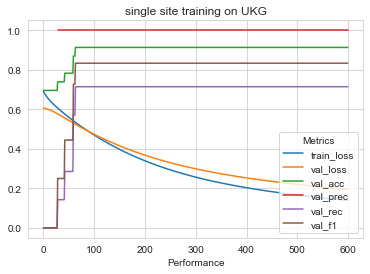

single site training on UKG
test loss 0.17740748822689056
test_acc 0.9605263157894737
test_prec 0.975
test_rec 0.9176470588235294
test_f1 0.9454545454545454




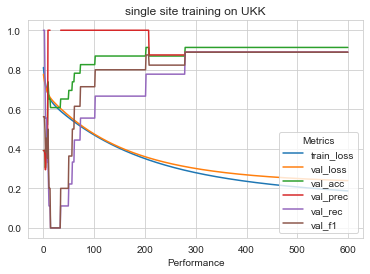

single site training on UKK
test loss 0.20624695718288422
test_acc 0.956140350877193
test_prec 0.9411764705882353
test_rec 0.9411764705882353
test_f1 0.9411764705882353




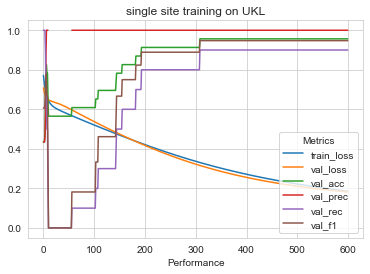

single site training on UKL
test loss 0.18954144418239594
test_acc 0.956140350877193
test_prec 1.0
test_rec 0.8823529411764706
test_f1 0.9375




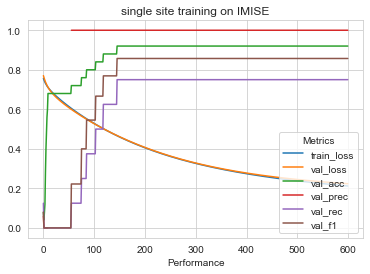

single site training on IMISE
test loss 0.1916118562221527
test_acc 0.956140350877193
test_prec 1.0
test_rec 0.8823529411764706
test_f1 0.9375




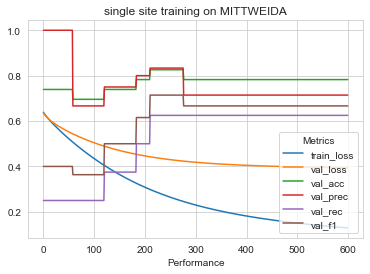

single site training on MITTWEIDA
test loss 0.19635115563869476
test_acc 0.9298245614035088
test_prec 0.9156626506024096
test_rec 0.8941176470588236
test_f1 0.9047619047619048




In [10]:
input_dim = 30
hidden_dim = 64
num_classes = 2

learning_rate = 0.01
weight_decay = 0.0005
num_epochs = 600

criterion = nn.CrossEntropyLoss()

for idx in range(len(station_list)):
    scaler = StandardScaler()
    df_X = station_dfs[idx][X_FEATURES]
    df_Y = station_dfs[idx][Y_FEATURE]
    df_X = scaler.fit_transform(df_X)
    df_Y.replace(to_replace=dict(M=1, B=0), inplace=True)
    df_Y = df_Y.to_numpy()
    X_train, X_val, y_train, y_val = train_test_split(df_X, df_Y, test_size=0.4, random_state=42)

    model = LogisticRegression(input_dim, hidden_dim, num_classes)
    optim = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    losses = []
    val_losses = []
    val_accs = []
    val_precs = []
    val_recs = []
    val_f1s = []
    for epoch in range(num_epochs):
        perm = np.arange(X_train.shape[0])
        np.random.shuffle(perm)
        X_train = X_train[perm]
        y_train = y_train[perm]
        loss = train(X_train, y_train, model, criterion, optim)
        val_loss, val_acc, val_precesion, val_recall, val_f1_score = valid(X_val, y_val, model, criterion)
        losses.append(loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_precs.append(val_precesion)
        val_recs.append(val_recall)
        val_f1s.append(val_f1_score)
    test_loss, test_acc, test_precesion, test_recall, test_f1_score = valid(X_test, y_test, model, criterion)
    plt.figure()
    plt.plot(losses, label="train_loss")
    plt.plot(val_losses, label="val_loss")
    plt.plot(val_accs, label="val_acc")
    plt.plot(val_precs, label="val_prec")
    plt.plot(val_recs, label="val_rec")
    plt.plot(val_f1s, label="val_f1")
    plt.legend(title="Metrics", loc="lower right")
    plt.title("single site training on {}".format(station_list[idx].upper())),
    plt.xlabel("Epoch")
    plt.xlabel("Performance")
    plt.show()
    print("single site training on {}".format(station_list[idx].upper()))
    print("test loss", test_loss)
    print("test_acc", test_acc)
    print("test_prec", test_precesion)
    print("test_rec", test_recall)
    print("test_f1", test_f1_score)
    print("\n")

## Institutional Incremental Learning

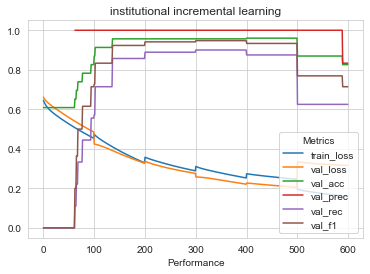

institutional incremental learning
test loss 0.1739557832479477
test_acc 0.9473684210526315
test_prec 0.9506172839506173
test_rec 0.9058823529411765
test_f1 0.927710843373494




In [11]:
input_dim = 30
hidden_dim = 64
num_classes = 2

learning_rate = 0.01
weight_decay = 0.0005
num_epochs = 100

criterion = nn.CrossEntropyLoss()
model = LogisticRegression(input_dim, hidden_dim, num_classes)

losses = []
val_losses = []
val_accs = []
val_precs = []
val_recs = []
val_f1s = []
for idx in range(len(station_list)):
    optim = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scaler = StandardScaler()
    df_X = station_dfs[idx][X_FEATURES]
    df_Y = station_dfs[idx][Y_FEATURE]
    df_X = scaler.fit_transform(df_X)
    df_Y.replace(to_replace=dict(M=1, B=0), inplace=True)
    df_Y = df_Y.to_numpy()
    X_train, X_val, y_train, y_val = train_test_split(df_X, df_Y, test_size=0.4, random_state=42)
    for epoch in range(num_epochs):
        perm = np.arange(X_train.shape[0])
        np.random.shuffle(perm)
        X_train = X_train[perm]
        y_train = y_train[perm]
        loss = train(X_train, y_train, model, criterion, optim)
        val_loss, val_acc, val_precesion, val_recall, val_f1_score = valid(X_val, y_val, model, criterion)
        losses.append(loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_precs.append(val_precesion)
        val_recs.append(val_recall)
        val_f1s.append(val_f1_score)

test_loss, test_acc, test_precesion, test_recall, test_f1_score = valid(X_test, y_test, model, criterion)    
plt.figure()
plt.plot(losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.plot(val_accs, label="val_acc")
plt.plot(val_precs, label="val_prec")
plt.plot(val_recs, label="val_rec")
plt.plot(val_f1s, label="val_f1")
plt.legend(title="Metrics", loc="lower right")
plt.title("institutional incremental learning")
plt.xlabel("Epoch")
plt.xlabel("Performance")
plt.show()
print("institutional incremental learning")
print("test loss", test_loss)
print("test_acc", test_acc)
print("test_prec", test_precesion)
print("test_rec", test_recall)
print("test_f1", test_f1_score)
print("\n")
    

## Cyclic Institutional Increamental Learning (CIIL)

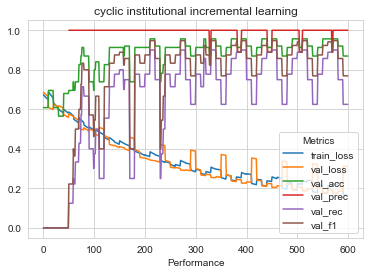

cyclic institutional incremental learning
test loss 0.18104307353496552
test_acc 0.9517543859649122
test_prec 0.9743589743589743
test_rec 0.8941176470588236
test_f1 0.9325153374233128




In [12]:
input_dim = 30
hidden_dim = 64
num_classes = 2

learning_rate = 0.01
weight_decay = 0.0005
num_cycles = 10
num_epochs = 10

criterion = nn.CrossEntropyLoss()
model = LogisticRegression(input_dim, hidden_dim, num_classes)

losses = []
val_losses = []
val_accs = []
val_precs = []
val_recs = []
val_f1s = []
for cycle in range(num_cycles):
    for idx in range(len(station_list)):
        optim = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        scaler = StandardScaler()
        df_X = station_dfs[idx][X_FEATURES]
        df_Y = station_dfs[idx][Y_FEATURE]
        df_X = scaler.fit_transform(df_X)
        df_Y.replace(to_replace=dict(M=1, B=0), inplace=True)
        df_Y = df_Y.to_numpy()
        X_train, X_val, y_train, y_val = train_test_split(df_X, df_Y, test_size=0.4, random_state=42)
        for epoch in range(num_epochs):
            perm = np.arange(X_train.shape[0])
            np.random.shuffle(perm)
            X_train = X_train[perm]
            y_train = y_train[perm]
            loss = train(X_train, y_train, model, criterion, optim)
            val_loss, val_acc, val_precesion, val_recall, val_f1_score = valid(X_val, y_val, model, criterion)
            losses.append(loss)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_precs.append(val_precesion)
            val_recs.append(val_recall)
            val_f1s.append(val_f1_score)

test_loss, test_acc, test_precesion, test_recall, test_f1_score = valid(X_test, y_test, model, criterion)    
plt.figure()
plt.plot(losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.plot(val_accs, label="val_acc")
plt.plot(val_precs, label="val_prec")
plt.plot(val_recs, label="val_rec")
plt.plot(val_f1s, label="val_f1")
plt.legend(title="Metrics", loc="lower right")
plt.title("cyclic institutional incremental learning"),
plt.xlabel("Epoch")
plt.xlabel("Performance")
plt.show()
print("cyclic institutional incremental learning")
print("test loss", test_loss)
print("test_acc", test_acc)
print("test_prec", test_precesion)
print("test_rec", test_recall)
print("test_f1", test_f1_score)
print("\n")
    